In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import spacy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from scipy import interp
from itertools import cycle
import random
import string

from sklearn.model_selection import KFold
from sklearn.model_selection import ParameterGrid
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

## Background

With thirty articles from biology, machine learning, and psychology at hand, our goal is to be able to classify sentences into five classes:

- Aim (AIMX): the specific research goal of the paper
- Own (OWNX): the author's own work, e.g. methods, results, conclusions
- Contrast (CONT): contrast, comparison or critique of past work
- Basis (BASE): past work that provides the basis for the work in the article
- Misc (MISC): any other sentences

To achieve this goal, we will convert our data set into tf idf matrix and train three classifiers: logistic regression (lasso and ridge), support vector machine classifier, and random forest classifier. We will evaluate these models and pick the best performing model.

# Part I. Data: Original Articles

## I. Preprocessing

### 1. Loading The Articles

In [2]:
import os  
path = '/Users/admin/Documents/SentenceCorpus/labeled_articles/'
all_files = os.listdir(path)

In [3]:
print(all_files)

['jdm_annotate3_120_1.txt', 'plos_annotate5_1375_2.txt', 'jdm_annotate2_107_1.txt', 'arxiv_annotate10_7_1.txt', 'plos_annotate5_1375_3.txt', 'plos_annotate10_1140_1.txt', 'plos_annotate10_1140_3.txt', 'plos_annotate5_1375_1.txt', 'jdm_annotate3_120_2.txt', 'jdm_annotate2_107_2.txt', 'arxiv_annotate10_7_3.txt', 'arxiv_annotate10_7_2.txt', 'jdm_annotate2_107_3.txt', 'jdm_annotate3_120_3.txt', 'plos_annotate10_1140_2.txt', 'plos_annotate7_1233_1.txt', 'arxiv_annotate7_268_3.txt', '.DS_Store', 'jdm_annotate4_220_3.txt', 'jdm_annotate4_220_2.txt', 'arxiv_annotate9_279_1.txt', 'arxiv_annotate7_268_2.txt', 'plos_annotate8_123_1.txt', 'plos_annotate7_1233_2.txt', 'plos_annotate8_123_3.txt', 'arxiv_annotate9_279_3.txt', 'jdm_annotate4_220_1.txt', 'arxiv_annotate9_279_2.txt', 'arxiv_annotate7_268_1.txt', 'plos_annotate8_123_2.txt', 'plos_annotate7_1233_3.txt', 'jdm_annotate10_210_3.txt', 'arxiv_annotate5_240_1.txt', 'jdm_annotate10_210_2.txt', 'arxiv_annotate5_240_2.txt', 'arxiv_annotate5_240_3.

In [4]:
all_files = [file for file in all_files if file != '.DS_Store']

In [5]:
articles = pd.DataFrame(np.zeros(4000))
num = 0

for file in all_files: 
    doc = open(path+file)
    read = doc.readlines()
    end = len(read)
    new_array = np.array([[line] for line in read if (line != '### abstract ###\n' and line != '### introduction ###\n')])
    end = len(new_array)-1
    articles.loc[num:num+end] = new_array
    num+=end
       

In [6]:
articles = articles[articles[0]!= 0]

In [7]:
articles.head()

,0
0,AIMX\twe test in the context of a dictator gam...
1,OWNX\twe manipulated the likelihood that indiv...
2,OWNX\tour analysis reveals a positive and sign...
3,OWNX\tthe magnitude of the effect is of econom...
4,OWNX\twe conclude that subtle cues might prove...


In [8]:
articles.shape

(3028, 1)

### 2. Cleaning The Sentences

In [9]:
import re

pattern = re.compile(r'\b[A-Z]+\b')

In [10]:
def splitter(row):
    pattern = re.compile(r'\b[A-Z]+\b')   
    #if the article follows the \t format
    try:
        first_part, second_part = row[0].split('\t')
        
    #if the article doesn't follow the \t format
    except (ValueError, TypeError):
        #match the pattern and extract the index
        #print(pattern.match(list(row)[0]).span()[1])
        div_index = pattern.match(list(row)[0]).span()[1]
        first_part, second_part = row[0][:div_index], row[0][div_index+1:]
    print('ONE!!!', first_part, 'TWO!!!!', second_part)
    return second_part, first_part

In [11]:
labels = []
texts = []
for row in articles[0]:
    try:
        first_part, second_part = row.split('\t')
        
    #if the article doesn't follow the \t format
    except (ValueError, TypeError):
        #match the pattern and extract the index
        div_index = pattern.match(row).span()[1]
        first_part, second_part = row[:div_index], row[div_index+1:]
    labels.append(first_part.strip())
    texts.append(second_part.strip())

In [12]:
len(labels)

3028

In [13]:
articles['texts'] = texts
articles['labels'] = labels

In [14]:
articles.head()

,0,texts,labels
0,AIMX\twe test in the context of a dictator gam...,we test in the context of a dictator game the ...,AIMX
1,OWNX\twe manipulated the likelihood that indiv...,we manipulated the likelihood that individuals...,OWNX
2,OWNX\tour analysis reveals a positive and sign...,our analysis reveals a positive and significan...,OWNX
3,OWNX\tthe magnitude of the effect is of econom...,the magnitude of the effect is of economic sig...,OWNX
4,OWNX\twe conclude that subtle cues might prove...,we conclude that subtle cues might prove suffi...,OWNX


In [15]:
len(texts)

3028

### 3. Unique Data - Removal of Duplicate Sentences

It turns out that a large portion of the sentences appears in more than one article. For more accurate modelling, we will remove all such sentences from the data set.

In [16]:
#apparently not all sentences in our data set are unique
articles['texts'].nunique()

1293

In [17]:
articles = articles.iloc[:, 1:]

In [18]:
articles.nunique()

texts     1293
labels       5
dtype: int64

In [19]:
no_dup_articles = articles.drop_duplicates(subset=['texts'])

In [20]:
no_dup_articles.nunique()

texts     1293
labels       5
dtype: int64

## II. Preparation for Modelling

### 1. Train Test Split

In [21]:
X = no_dup_articles['texts']
y=no_dup_articles['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=108)

In [22]:
len(X_train)

905

In [23]:
len(X_test)

388

### 2. Class Imbalance

In [24]:
np.unique(y_train, return_counts=True)

(array(['AIMX', 'BASE', 'CONT', 'MISC', 'OWNX'], dtype=object),
 array([ 61,  21,  51, 535, 237]))

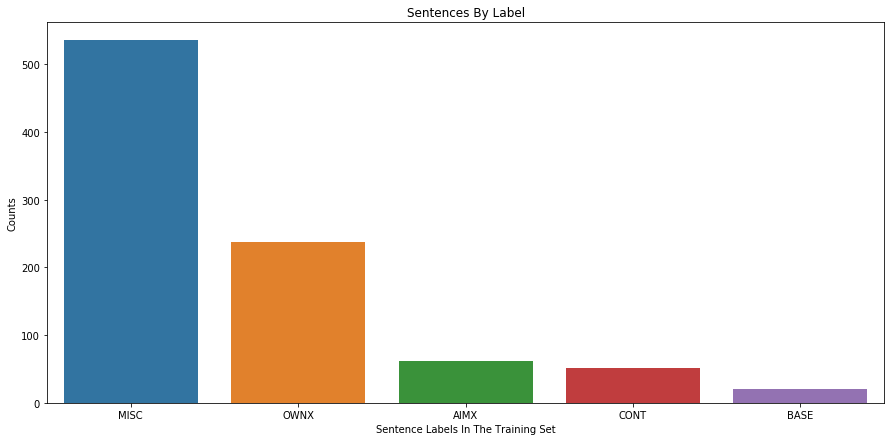

In [25]:
plt.figure(figsize=(15,7))

sns.countplot(x=y_train)
plt.title('Sentences By Label')
plt.xlabel('Sentence Labels In The Training Set')
plt.ylabel('Counts')
plt.show()

In [26]:
#preprocessing the texts

nlp = spacy.load('en')

# since we have a rather small corpus, it makes sense to lemmatize all words

def processor(data, lemmatize=True):
    lemmas = []
    for entry in data:
        entry_parsed = nlp(entry)
        string = ''
        for token in entry_parsed:
            if (not token.is_punct
                and not token.is_stop): # remove all the stop words
                 
                if lemmatize ==True:
                    string += token.lemma_ + ' '
                else:
                    string += str(token)+ ' '
                string = string.replace('-', '')
                string = string.replace('PRON', '')
                
        lemmas.append(string.rstrip())
 
    return lemmas

In [27]:
X_train_processed = processor(X_train)

In [28]:
X_train_processed[:5]

['importantly iapp rodent specie rat mouse iapp lose capacity aggregate amyloid fibril citation transgenic mouse model express human iapp develop islet deposit citation',
 ' obvious proof paper conditionaliz',
 'case low likelihood slope expect weakly positive',
 'furthermore convert mathematical model quantitatively integrate gene expression datum reaction constraint compute functional network state compare report experimental datum',
 'in paper introduce radically new approach base machine learning technique map ases internet natural as taxonomy']

In [29]:
X_test_processed = processor(X_test)

### 3. One-Hot Encoding for Classes

In [30]:
# We will need to encode classes as numbers.
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

### 4. Oversampling

We are dealing with class imbalance. Since our data set is rather small, it would be challenging to use undersampling. Alternatively, we could use oversampling of the underrepresented classes.

In [31]:
X_train_concat = pd.DataFrame({'texts': X_train_processed, 'classes': y_train_encoded})

In [32]:
X_train_concat.head()

,texts,classes
0,importantly iapp rodent specie rat mouse iapp ...,3
1,obvious proof paper conditionaliz,4
2,case low likelihood slope expect weakly positive,4
3,furthermore convert mathematical model quantit...,4
4,in paper introduce radically new approach base...,0


In [33]:
np.unique(X_train_concat['classes'], return_counts=True)

(array([0, 1, 2, 3, 4]), array([ 61,  21,  51, 535, 237]))

In [34]:
# resampling data to tackle class imbalance

X_train_zero = (X_train_concat[X_train_concat['classes']==0]).sample(535, random_state=108, replace=True)
X_train_one = (X_train_concat[X_train_concat['classes']==1]).sample(535, random_state=108, replace=True)
X_train_two = (X_train_concat[X_train_concat['classes']==2]).sample(535, random_state=108, replace=True)
X_train_three = X_train_concat[X_train_concat['classes']==3]
X_train_four = (X_train_concat[X_train_concat['classes']==4]).sample(535, random_state=108, replace=True)

In [35]:
X_train_balanced_over = pd.concat([X_train_zero
                                  ,X_train_one
                                  ,X_train_two
                                  ,X_train_three 
                                  ,X_train_four], axis=0, ignore_index=True)

In [36]:
X_train_balanced_over.shape

(2675, 2)

In [37]:
X_train_balanced_over = X_train_balanced_over.sample(2675)

In [38]:
y_train_balanced_over = X_train_balanced_over ['classes']

In [39]:
np.unique(X_train_balanced_over['classes'], return_counts=True)

(array([0, 1, 2, 3, 4]), array([535, 535, 535, 535, 535]))

### 5. Binarize The Training and Test Target Variables

In [40]:
# binarization necessary for roc_auc curve 
from sklearn.preprocessing import label_binarize
y_tr_binary = label_binarize(y_train_balanced_over , classes =[0, 1, 2, 3, 4])
y_test_binary = label_binarize(y_test_encoded, classes =[0, 1, 2, 3, 4])

### 6. Feature Generation: TF IDF Matrix

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_over = TfidfVectorizer(max_df=0.8, 
                             min_df=7, 
                             stop_words='english', 
                             lowercase=True, 
                             use_idf=True,
                             norm=u'l2',
                             smooth_idf=True
                            )

In [42]:
X_train_balanced_over['texts'].head()

885     in study extend refined early work allen et al...
2354         game pit pro social motivation self interest
663     to accomplish propose sparse variant indian bu...
2503     stochastic gating axonal dendritic ion channe...
1981    504 possible variant enumerate 62 study detail...
Name: texts, dtype: object

In [43]:
X_train_tfidf_over=vectorizer_over.fit_transform(X_train_balanced_over['texts'])

print("Number of features: %d" % X_train_tfidf_over.get_shape()[1])

Number of features: 959


In [44]:
X_test_tfidf_over = vectorizer_over.transform(X_test_processed)

In [45]:
vectorizer_reg = TfidfVectorizer(max_df=0.8, 
                             min_df=7, 
                             stop_words='english', 
                             lowercase=True, 
                             use_idf=True,
                             norm=u'l2',
                             smooth_idf=True
                            )

In [46]:
X_train_tfidf_reg=vectorizer_reg.fit_transform(X_train_processed)

print("Number of features: %d" % X_train_tfidf_reg.get_shape()[1])

Number of features: 461


In [47]:
X_test_tfidf_reg = vectorizer_reg.transform(X_test_processed)

## III. Training Classifiers

The hyperparameters for each classifier hyperparameters will be selected based on cross-validation.

### 1. Logistic Regression

### a) Parameter Finetuning on The Training Set

In [48]:
kf = KFold(n_splits = 5, random_state=108)
accross_folds = []

param_grid = {'penalty': ['l1', 'l2'],
             'C': [1e-3,1e-2,1e-1,1,1e1,1e2]}

grid = ParameterGrid(param_grid)
parameters = []
scores = []

for params in grid:
    accross_folds = []
    for train_index, test_index in kf.split(X_train_tfidf_over):
        X_train, X_test = X_train_tfidf_over[train_index], X_train_tfidf_over[test_index]
        y_train, y_test = y_tr_binary[train_index], y_tr_binary[test_index]
        logistic = OneVsRestClassifier(LogisticRegression(**params))
        y_score = logistic.fit(X_train, y_train).predict_proba(X_test)
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        n_classes = 5
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

       

        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        #roc_auc_score = roc_auc_score(y_test, y_score, average='weighted')
        accross_folds.append(roc_auc["macro"])
    parameters.append(params)
    scores.append(np.mean(accross_folds))

In [49]:
df_logistic = pd.DataFrame(scores, columns = ['roc_auc'])
df_logistic['Cs'] = parameters
df_logistic.sort_values(by=['roc_auc'], ascending=False)[:3]

,roc_auc,Cs
9,0.984876,"{'C': 10.0, 'penalty': 'l2'}"
11,0.983422,"{'C': 100.0, 'penalty': 'l2'}"
8,0.978682,"{'C': 10.0, 'penalty': 'l1'}"


### b) Validation on The Test Set

In [50]:
logistic_final = OneVsRestClassifier(LogisticRegression(C=10, penalty='l2'))

logistic_final.fit(X_train_tfidf_over, y_tr_binary)
y_score_logistic = logistic_final.predict_proba(X_test_tfidf_over)

n_classes = 5

fpr_log = dict()
tpr_log = dict()
roc_auc_log = dict()
for i in range(n_classes):
    fpr_log[i], tpr_log[i], _ = roc_curve(y_test_binary[:, i], y_score_logistic[:, i])
    roc_auc_log[i] = auc(fpr_log[i], tpr_log[i])

fpr_log["micro"], tpr_log["micro"], _ = roc_curve(y_test_binary.ravel(), y_score_logistic.ravel())
roc_auc_log["micro"] = auc(fpr_log["micro"], tpr_log["micro"])

all_fpr_log = np.unique(np.concatenate([fpr_log[i] for i in range(n_classes)]))


mean_tpr_log = np.zeros_like(all_fpr_log)

for i in range(n_classes):
    mean_tpr_log += interp(all_fpr_log, fpr_log[i], tpr_log[i])


mean_tpr_log /= n_classes

fpr_log["macro"] = all_fpr_log
tpr_log["macro"] = mean_tpr_log
roc_auc_log["macro"] = auc(fpr_log["macro"], tpr_log["macro"])
#print(roc_auc["micro"], 
print(roc_auc_log["macro"])

0.8453162582513715


### 2. SVC

### a) Parameter Finetuning On The Training Set

In [51]:
from sklearn.svm import SVC

kf = KFold(n_splits = 5, random_state=108)
accross_folds = []

param_grid = [{'C': [1e-3, 1e-2, 1e-1, 1, 1e1, 20, 1e2, 1e3,1e4 ],
             'gamma': [1e-3, 1e-2, 1e-1, 1, 'auto']}
                           ]        
grid = ParameterGrid(param_grid)
parameters = []
scores = []
for params in grid:
    accross_folds = []
    for train_index, test_index in kf.split(X_train_tfidf_over):
        X_train, X_test = X_train_tfidf_over[train_index], X_train_tfidf_over[test_index]
        y_train, y_test = y_tr_binary[train_index], y_tr_binary[test_index]
        svc = OneVsRestClassifier(SVC(**params, probability=True))
        y_score = svc.fit(X_train, y_train)
        y_score = svc.predict_proba(X_test)
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(5):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

       
        n_classes = 5
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(5)]))

        
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])

       
        mean_tpr /= 5

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        
        accross_folds.append(roc_auc["macro"])
    parameters.append(params)
    scores.append(np.mean(accross_folds))

In [52]:
df_svc = pd.DataFrame(scores, columns = ['roc_auc'])
df_svc['params'] = parameters
df_svc.sort_values(by=['roc_auc'], ascending=False)[:3]

,roc_auc,params
18,0.990842,"{'C': 1, 'gamma': 1}"
23,0.990817,"{'C': 10.0, 'gamma': 1}"
43,0.990675,"{'C': 10000.0, 'gamma': 1}"


### b) Validation on The Test Set

In [53]:
svc_final = OneVsRestClassifier(SVC(C=1, gamma=1, probability=True))
svc_final.fit(X_train_tfidf_over, y_tr_binary)
y_score_svc = svc_final.predict_proba(X_test_tfidf_over)

n_classes = 5
fpr_svc = dict()
tpr_svc = dict()
roc_auc_svc = dict()

for i in range(n_classes):
    fpr_svc[i], tpr_svc[i], _ = roc_curve(y_test_binary[:, i], y_score_svc[:, i])
    roc_auc_svc[i] = auc(fpr_svc[i], tpr_svc[i])



fpr_svc["micro"], tpr_svc["micro"], _ = roc_curve(y_test_binary.ravel(), y_score_svc.ravel())
roc_auc_svc["micro"] = auc(fpr_svc["micro"], tpr_svc["micro"])

all_fpr_svc = np.unique(np.concatenate([fpr_svc[i] for i in range(n_classes)]))

mean_tpr_svc = np.zeros_like(all_fpr_svc)

for i in range(n_classes):
    mean_tpr_svc += interp(all_fpr_svc, fpr_svc[i], tpr_svc[i])


mean_tpr_svc /= n_classes

fpr_svc["macro"] = all_fpr_svc
tpr_svc["macro"] = mean_tpr_svc

roc_auc_svc["macro"] = auc(fpr_svc["macro"], tpr_svc["macro"])

print(roc_auc_svc["macro"])


0.839682702908342


### 3. Random Forest Classifier

### a) Parameter Finetuning on the Training Set

In [54]:

kf = KFold(n_splits = 5, random_state=108)
accross_folds = []

param_grid_rfc = [
                {'n_estimators': [100, 500, 700, 1000, 1200],
                'max_depth': [5, 8, 12, 20, 30, 50, 70, 100, 120, 150]}
    
                ]
grid = ParameterGrid(param_grid_rfc)
parameters = []
scores = []
for params in grid:
    accross_folds = []
    for train_index, test_index in kf.split(X_train_tfidf_over):
        X_train, X_test = X_train_tfidf_over[train_index], X_train_tfidf_over[test_index]
        y_train, y_test = y_tr_binary[train_index], y_tr_binary[test_index]
        rfc = RandomForestClassifier(**params, n_jobs = -1)
        y_score = rfc.fit(X_train, y_train).predict_proba(X_test)
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(5):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[i][:, 1])
            roc_auc[i] = auc(fpr[i], tpr[i])

        n_classes = 5
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(5)]))

        
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])

        
        mean_tpr /= 5

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        
        accross_folds.append(roc_auc["macro"])
    parameters.append(params)
    scores.append(np.mean(accross_folds))

In [55]:
df_rfc = pd.DataFrame(scores, columns = ['roc_auc'])
df_rfc['params'] = parameters
df_rfc.sort_values(by=['roc_auc'], ascending=False)[:3]

,roc_auc,params
48,0.993210,"{'max_depth': 150, 'n_estimators': 1000}"
44,0.993173,"{'max_depth': 120, 'n_estimators': 1200}"
49,0.993054,"{'max_depth': 150, 'n_estimators': 1200}"


In [56]:

kf = KFold(n_splits = 5, random_state=108)
accross_folds = []

param_grid_rfc = [
                {'max_features': ['auto', 'sqrt'],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'bootstrap': [True, False]}
                            ]
grid = ParameterGrid(param_grid_rfc)
parameters = []
scores = []
for params in grid:
    accross_folds = []
    for train_index, test_index in kf.split(X_train_tfidf_over):
        X_train, X_test = X_train_tfidf_over[train_index], X_train_tfidf_over[test_index]
        y_train, y_test = y_tr_binary[train_index], y_tr_binary[test_index]
        rfc = RandomForestClassifier(**params, n_estimators = 1000, max_depth = 150, n_jobs = -1)
        y_score = rfc.fit(X_train, y_train).predict_proba(X_test)
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(5):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[i][:, 1])
            roc_auc[i] = auc(fpr[i], tpr[i])

        n_classes = 5
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(5)]))

        
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])

       
        mean_tpr /= 5

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        
        accross_folds.append(roc_auc["macro"])
    parameters.append(params)
    scores.append(np.mean(accross_folds))

In [57]:
df_rfc = pd.DataFrame(scores, columns = ['roc_auc'])
df_rfc['params'] = parameters
df_rfc.sort_values(by=['roc_auc'], ascending=False)[:3]

,roc_auc,params
1,0.993382,"{'bootstrap': True, 'max_features': 'auto', 'm..."
10,0.993245,"{'bootstrap': True, 'max_features': 'sqrt', 'm..."
29,0.993211,"{'bootstrap': False, 'max_features': 'sqrt', '..."


In [58]:
df_rfc.iloc[29, 1]

{'bootstrap': False,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10}

### b) Validation On The Test Set

In [59]:
rfc_final = RandomForestClassifier(n_estimators = 1000, 
                                   max_depth = 150, 
                                   bootstrap= False,
                                   max_features= 'sqrt',
                                   min_samples_leaf=1,
                                   min_samples_split= 10,
                                   n_jobs = -1)

rfc_final.fit(X_train_tfidf_over, y_tr_binary)
y_score_rfc = rfc_final.predict_proba(X_test_tfidf_over)

n_classes = 5

fpr_rfc = dict()
tpr_rfc = dict()
roc_auc_rfc = dict()

for i in range(n_classes):
    fpr_rfc[i], tpr_rfc[i], _ = roc_curve(y_test_binary[:, i], y_score_rfc[i][:, 1])
    roc_auc_rfc[i] = auc(fpr_rfc[i], tpr_rfc[i])


all_fpr_rfc = np.unique(np.concatenate([fpr_rfc[i] for i in range(n_classes)]))

mean_tpr_rfc = np.zeros_like(all_fpr_rfc)

for i in range(n_classes):
    mean_tpr_rfc += interp(all_fpr_rfc, fpr_rfc[i], tpr_rfc[i])

mean_tpr_rfc /= 5

fpr_rfc["macro"] = all_fpr_rfc
tpr_rfc["macro"] = mean_tpr_rfc

roc_auc_rfc["macro"] = auc(fpr_rfc["macro"], tpr_rfc["macro"])

print(roc_auc_rfc["macro"])

0.8166257762563028


## IV. The Best Model: Logistic Regression (Lasso)

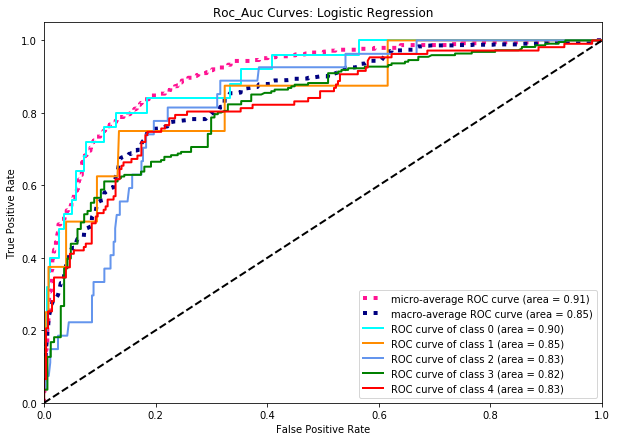

In [60]:
lw=2
# Plot all ROC curves
plt.figure(figsize = (10, 7))
plt.plot(fpr_log["micro"], tpr_log["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_log["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr_log["macro"], tpr_log["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_log["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_log[i], tpr_log[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc_log[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc_Auc Curves: Logistic Regression')
plt.legend(loc="lower right")
plt.show()

In [61]:
pred_logistic = logistic_final.fit(X_train_tfidf_over, y_train_balanced_over).predict_proba(X_test_tfidf_over)

Confusion matrix we create depends on the thresholds we set for each class. These thresholds can be adjusted based on the goals of the potential end users of the model.

In [62]:
def threshold_changer(pred_probs):    
    predicted_class = []
    for entry in pred_probs:
        thresholder = pd.DataFrame()
        classes = []
        zero_or_ones = []
        probabilities = []
      
        for cl, probs in enumerate(entry):
            classes.append(cl)
            probabilities.append(probs)

        thresholder['classes'] =classes
        thresholder['probabilities'] = probabilities

        
        if (thresholder[thresholder['classes']==0].iloc[0, 1]) >=0.3:
            predicted_class.append(0)
        elif (thresholder[thresholder['classes']==1].iloc[0, 1]) >=0.3:
            predicted_class.append(1)
        elif (thresholder[thresholder['classes']==2].iloc[0, 1]) >=0.08:
            predicted_class.append(2)
        elif (thresholder[thresholder['classes']==4].iloc[0, 1]) >=0.2:
            predicted_class.append(4)
        else:
            predicted_class.append(3)
    return predicted_class


In [63]:
y_pred_logistic = threshold_changer(pred_logistic )

print(confusion_matrix(y_test_encoded, y_pred_logistic))

[[ 15   0   3   2   5]
 [  0   3   1   3   1]
 [  2   0  19   2   4]
 [  4   2  45 128  42]
 [  6   3  22   8  68]]


# Part II. Noise In The Data

To pose an additional challenge, we will insert, change or delete one to three letters in words (in 10% of the data).

### 1. Creation of A Noisy Data Set

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=108)

In [65]:
import random
import string

In [66]:
# a function generating a specified number of random letters
def random_char(number):
       return ''.join(random.choice(string.ascii_letters) for x in range(number))


In [67]:
# a function generating a specified number of random numbers in a specified range

def random_generator(number, max_num):
    random_generated = []
    for num in range(number):
        rand_num = random.randint(1, max_num)
        random_generated.append(rand_num)
    return random_generated

In [68]:
# a function that adds noise to the data
def noiser(data):
    words = []
    for entry in data:
        entry_parsed = nlp(entry)
        string = ''

        
        # to make sure that at least one word is altered in each sentence regardless of its length
        how_many_words = np.amax([1, round(len(entry_parsed)*0.1)])
        how_many_letters = random.randint(1, 3)
        
        #one for insertion, two for replacement, three for deletion
        which_method = random.randint(1, 3)
       
        rand_numbers = random_generator(how_many_words, len(entry_parsed))
        for num, token in enumerate(entry_parsed):
            str_token = str(token)
            if num in rand_numbers:
                cutoff = random.randint(1, len(token))
                #insertion of random letters
                if which_method ==1:
                    str_token = str_token[:int(cutoff)] + random_char(how_many_letters)+ str_token[cutoff:] 

                #replacement of random letters    
                elif which_method == 2:
                    str_token = str_token[:cutoff] + random_char(how_many_letters)+ str_token[cutoff+how_many_letters:] 

                #deletion of random letters
                elif which_method == 3:
                    str_token = str_token[:cutoff] + str_token[cutoff+how_many_letters:]
            string += str_token + ' '
            string = string.replace('-', '')


        words.append(string.rstrip())
    return words

In [69]:
X_train_noised = noiser(X_train)

In [70]:
X_test_noised = noiser(X_test)

In [71]:
X_train_processed_noised = processor(X_train_noised, lemmatize=True)

In [72]:
X_test_processed_noised = processor(X_test_noised, lemmatize=True)

In [73]:
X_train_processed_noised[:5]

['importantly iapdrrp rodwbtent specie rat mouse iapp lose capacity aggregate amyloid fibril citation bucsxt tranfqcsgenic mouse model express human iapp develop islet deposit citation',
 ' ovious th proof paper conditionaliz',
 'case low likelihood cof tgyq slope expect weakly positive',
 'furthermore convert mathematical model quantitatively iegrate gene expression datum reaction constraint comte functional network state compare report experimeal datum',
 'in paper intnyduce radically new appghach base onpz machine learn technique map ases internet natural as taxonomy']

### 2. Oversampling To Tackle Class Imabalance

In [74]:
X_train_concat = pd.DataFrame({'texts': X_train_processed_noised, 'classes': y_train_encoded})

In [75]:
X_train_zero = (X_train_concat[X_train_concat['classes']==0]).sample(535, random_state=108, replace=True)
X_train_one = (X_train_concat[X_train_concat['classes']==1]).sample(535, random_state=108, replace=True)
X_train_two = (X_train_concat[X_train_concat['classes']==2]).sample(535, random_state=108, replace=True)
X_train_three = X_train_concat[X_train_concat['classes']==3]
X_train_four = (X_train_concat[X_train_concat['classes']==4]).sample(535, random_state=108, replace=True)

In [76]:
X_train_balanced_over = pd.concat([X_train_zero
                                  ,X_train_one
                                  ,X_train_two
                                  ,X_train_three 
                                  ,X_train_four], axis=0, ignore_index=True)

In [77]:
X_train_balanced_over.shape

(2675, 2)

In [78]:
#shuffle all classes 

X_train_balanced_over = X_train_balanced_over.sample(2675)

In [79]:
np.unique(X_train_balanced_over['classes'], return_counts = True)

(array([0, 1, 2, 3, 4]), array([535, 535, 535, 535, 535]))

In [80]:
y_train_balanced_over_encoded = X_train_balanced_over['classes']

In [81]:
y_tr_binary = label_binarize(y_train_balanced_over_encoded, classes =[0, 1, 2, 3, 4])

In [82]:
vectorizer_noised = TfidfVectorizer(max_df=0.8, 
                             min_df=7, 
                             stop_words='english', 
                             lowercase=True, 
                             use_idf=True,
                             norm=u'l2',
                             smooth_idf=True
                            )

In [83]:
X_train_tfidf_noised=vectorizer_noised.fit_transform(X_train_balanced_over['texts'])

print("Number of features: %d" % X_train_tfidf_noised.get_shape()[1])

Number of features: 1173


In [84]:
X_test_tfidf_noised = vectorizer_noised.transform(X_test_noised)

### 3. Training Logistic Regression

### a) Cross-Validation on the Noised Training Set

In [85]:
kf = KFold(n_splits = 5, random_state=108)
accross_folds = []

param_grid = {'penalty': ['l1', 'l2'],
             'C': [1e-3,1e-2,1e-1,1,1e1,1e2]}

grid = ParameterGrid(param_grid)
parameters = []
scores = []

for params in grid:
    accross_folds = []
    for train_index, test_index in kf.split(X_train_tfidf_noised):
        X_train, X_test = X_train_tfidf_noised[train_index], X_train_tfidf_noised[test_index]
        y_train, y_test = y_tr_binary[train_index], y_tr_binary[test_index]
        logistic = OneVsRestClassifier(LogisticRegression(**params))
        y_score = logistic.fit(X_train, y_train).predict_proba(X_test)
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        n_classes = 5
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

       

        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        accross_folds.append(roc_auc["macro"])
    parameters.append(params)
    scores.append(np.mean(accross_folds))

In [86]:
df_logistic = pd.DataFrame(scores, columns = ['roc_auc'])
df_logistic['Cs'] = parameters
df_logistic.sort_values(by=['roc_auc'], ascending=False)[:3]

,roc_auc,Cs
9,0.987460,"{'C': 10.0, 'penalty': 'l2'}"
11,0.986686,"{'C': 100.0, 'penalty': 'l2'}"
7,0.981739,"{'C': 1, 'penalty': 'l2'}"


### a) Test Set Evaluation

In [87]:
logistic_final = OneVsRestClassifier(LogisticRegression(C=10, penalty='l2'))

logistic_final.fit(X_train_tfidf_noised, y_tr_binary)
y_score_logistic = logistic_final.predict_proba(X_test_tfidf_noised)

n_classes = 5

fpr_log = dict()
tpr_log = dict()
roc_auc_log = dict()
for i in range(n_classes):
    fpr_log[i], tpr_log[i], _ = roc_curve(y_test_binary[:, i], y_score_logistic[:, i])
    roc_auc_log[i] = auc(fpr_log[i], tpr_log[i])

# Compute micro-average ROC curve and ROC area
fpr_log["micro"], tpr_log["micro"], _ = roc_curve(y_test_binary.ravel(), y_score_logistic.ravel())
roc_auc_log["micro"] = auc(fpr_log["micro"], tpr_log["micro"])

all_fpr_log = np.unique(np.concatenate([fpr_log[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr_log = np.zeros_like(all_fpr_log)
for i in range(n_classes):
    mean_tpr_log += interp(all_fpr_log, fpr_log[i], tpr_log[i])

# Finally average it and compute AUC
mean_tpr_log /= n_classes

fpr_log["macro"] = all_fpr_log
tpr_log["macro"] = mean_tpr_log
roc_auc_log["macro"] = auc(fpr_log["macro"], tpr_log["macro"])
#print(roc_auc["micro"], 
print(roc_auc_log["macro"])

0.7874068387928091


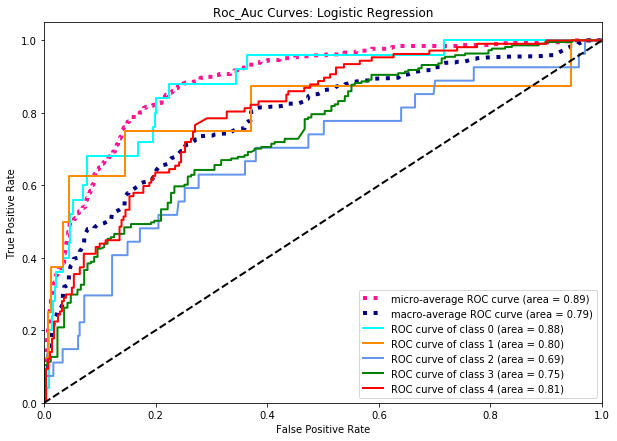

In [88]:
# Plot all ROC curves
plt.figure(figsize = (10, 7))
plt.plot(fpr_log["micro"], tpr_log["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_log["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr_log["macro"], tpr_log["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_log["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_log[i], tpr_log[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc_log[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc_Auc Curves: Logistic Regression')
plt.legend(loc="lower right")
plt.show()


In [89]:
pred_logistic = logistic_final.fit(X_train_tfidf_noised, y_train_balanced_over_encoded).predict_proba(X_test_tfidf_noised)

In [90]:
y_pred_logistic = threshold_changer(pred_logistic )

print(confusion_matrix(y_test_encoded, y_pred_logistic))

[[ 10   0   4   6   5]
 [  0   3   1   3   1]
 [  0   0  15   7   5]
 [  9   0  58 116  38]
 [  6   3  29  15  54]]


We witnessed a significant performance drop associated with the noise in the data. In real environment, this issue can be attributed to misspelling and mistyping. One way to tackle this problem is to run the our data through a spell checker.

## Additional Strategies to Explore:

In the future, this project can be improved by experimenting with alternative feature generation methods, e.g. application of Latent Semantic Analysis and creation of latent semantic components and n-grams instead of single tokens.